# Processing Bio optic data

This notebook process bio optic data from the eco-puk and PAR sensor. 

We will use a lot of functions from the glidertools package. 

## Import libraries and read glider data

The glider input data must be an OG1 type NCDF with profile index and ideally CTD QCed.

In [1]:
import glidertools as gt
import xarray as xr
import numpy as np
import os
import glob
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
from cmocean import cm as cmo

In [2]:
glider_name = 'Nelson'

In [3]:
# Get list of NetCDF files
nc_files = glob.glob(f"C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled/{glider_name}*profiled.nc")
# Read and concatenate datasets
for file in nc_files:
    ds = xr.open_dataset(file, decode_times=True)
    glider_name = ds.attrs.get("trajectory").split("_")[0]
    # Select variables of interest
    vars_of_interest = ["TIME", "DEPTH", "TEMP", "CHLA", "BBP700", "PRAC_SALINITY", "MOLAR_DOXY", "PROFILE_NUMBER", "LATITUDE", "LONGITUDE"]
    ds_sel = ds[vars_of_interest]
    # Convert to pandas DataFrame, then to polars DataFrame
    df_pd = ds_sel.to_dataframe().reset_index()
    df_pl = pl.from_pandas(df_pd)

    #Use only profiling data (-1 is surfacing behavior)
    #df_pl = df_pl.filter(pl.col("PROFILE_NUMBER") > 0)

    df_pl = df_pl.with_columns((pl.col("PROFILE_NUMBER").cast(pl.String) + "_" + glider_name).alias("profile_id"))
    print(f"{file} processed, shape: {df_pl.shape}")

    # Concatenate DataFrames
    if 'df_concat' in locals():
        df_concat = pl.concat([df_concat, df_pl])
    else:
        df_concat = df_pl

# Add a 'glider_name' column by extracting the part before '_' in 'profile_id'
df_concat = df_concat.with_columns(
    pl.col("profile_id").str.split("_").list.get(1).alias("glider_name")
)


C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/nc_profiled\Nelson_646_Profiled.nc processed, shape: (1993536, 12)


In [4]:
df_concat = (
    df_concat
    .sort(['profile_id', 'TIME'])
    .with_columns([
        pl.col('DEPTH')
        .interpolate()
        .over('profile_id')
        .alias('DEPTH_interp')
    ])
)

df_concat = (
    df_concat
    .sort(['profile_id', 'TIME'])
    .with_columns([
        pl.col('PRAC_SALINITY')
        .interpolate()
        .over('profile_id')
        .alias('PRAC_SALINITY_interp')
    ])
)

df_concat = (
    df_concat
    .sort(['profile_id', 'DEPTH_interp'])
    .with_columns([
        pl.col('TEMP')
        .interpolate()
        .over('profile_id')
        .alias('TEMP_interp')
    ])
)

In [5]:
df_raw= df_concat

dataset = xr.open_dataset(file)

## bbp

1) convert beta to bb to bbp
2) Split the bbp signal into baseline and spikes

In [6]:
theta = 124
xfactor = 1.076

In [7]:
# Calculate the minimum time per profile_number
dive_time = (
    df_raw
    .group_by("PROFILE_NUMBER")
    .agg([
        pl.col("TIME").min().alias("dive_time")
    ])
)

# Join the dive_time back to df_raw
df_raw = df_raw.join(dive_time, on="PROFILE_NUMBER", how="left")

c:\Users\flapet\OneDrive - NOC\Documents\risc_glider_demo\risc_env\lib\site-packages\glidertools\helpers.py:76: GliderToolsWarning: Primary input variable is not xr.DataArray data type - no metadata to pass on.
  warnings.warn(msg, category=GliderToolsWarning)
c:\Users\flapet\OneDrive - NOC\Documents\risc_glider_demo\risc_env\lib\site-packages\glidertools\mapping.py:969: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = Series(z).groupby([x, bins])  # -DB put z into the many bins (like 2D hist)
c:\Users\flapet\OneDrive - NOC\Documents\risc_glider_demo\risc_env\lib\site-packages\glidertools\mapping.py:969: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt th

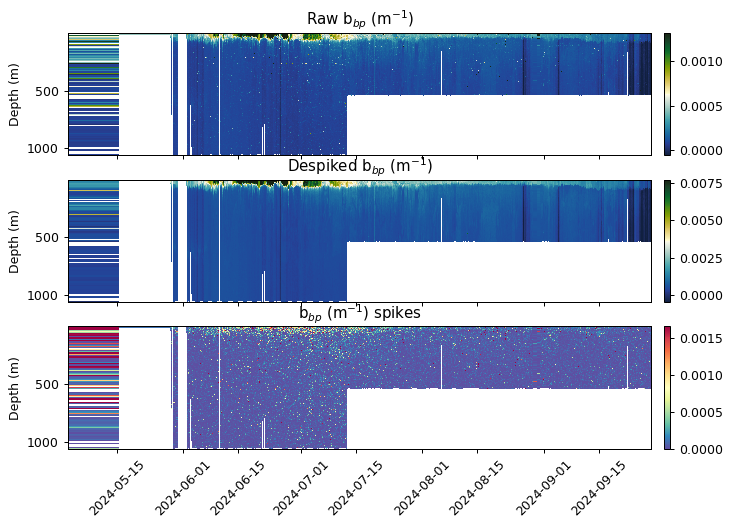

In [8]:
bbp_1d = np.array(df_raw['BBP700'])
prof_1d = np.array(df_raw['PROFILE_NUMBER'])
depth_1d = abs(np.array(df_raw['DEPTH_interp']))
time = np.array(df_raw['dive_time'])

nan_mask = np.isnan(depth_1d)
valid_idx = np.where(~nan_mask)[0]  # Indices of non-NaN values
valid_values = depth_1d[valid_idx]   # Non-NaN values
depth_1d[nan_mask] = np.interp(np.where(nan_mask)[0], valid_idx, valid_values)
time_1d = time[~nan_mask]

#bbp_horz = gt.cleaning.horizontal_diff_outliers(prof_1d, depth_1d, bbp_1d, depth_threshold=10, mask_frac=0.05)
bbp_corrected = gt.flo_functions.flo_bback_total(bbp_1d, df_raw['TEMP_interp'], df_raw['PRAC_SALINITY_interp'], theta, 700, xfactor)
bbp_baseline, bbp_spikes = gt.cleaning.despike(bbp_corrected, 7, spike_method='minmax')


fig, ax = plt.subplots(3, 1, figsize=[9, 6], sharex=True, dpi=90)

gt.plot.pcolormesh(time, depth_1d, bbp_1d, cmap=cmo.delta, ax=ax[0], robust=True)
gt.plot(time, depth_1d, bbp_baseline, cmap=cmo.delta, ax=ax[1], robust=True)
gt.plot(time, depth_1d, bbp_spikes, ax=ax[2], cmap=plt.cm.Spectral_r, vmin=0)

[a.set_xlabel('') for a in ax]

ax[0].set_title('Raw b$_{bp}$ (m$^{-1}$)')
ax[1].set_title('Despiked b$_{bp}$ (m$^{-1}$)')
ax[2].set_title('b$_{bp}$ (m$^{-1}$) spikes')

plt.show()

In [9]:
dataset['beta'] = ("N_MEASUREMENTS", bbp_1d)

dataset['beta'].attrs = {
    'description': 'Raw data of beta at 700 nm',
    'units' : 'm-1'
}
dataset['BBP700'] = ("N_MEASUREMENTS", bbp_corrected)

dataset['BBP700'].attrs = {
    'description': 'True value of bbp from beta computed using theta and chi factor',
    'units' : 'm-1',
    'theta': theta,
    'chi_factor': xfactor
}

dataset['BBP700_baseline'] = ("N_MEASUREMENTS", bbp_baseline)

dataset['BBP700_baseline'].attrs = {
    'description': 'Baseline value of bbp at 700 nm',
    'units' : 'm-1',
    'method': 'minmax',
}

dataset['BBP700_spikes'] = ("N_MEASUREMENTS", bbp_spikes)

dataset['BBP700_spikes'].attrs = {
    'description': 'Spikes values of bbp at 700 nm',
    'units' : 'm-1',
    'method': 'minmax',
}

In [10]:
display(dataset)

<xarray.Dataset> Size: 582MB
Dimensions:                               (N_MEASUREMENTS: 1993536, N_PARAM: 24)
Dimensions without coordinates: N_MEASUREMENTS, N_PARAM
Data variables: (12/77)
    TIME                                  (N_MEASUREMENTS) datetime64[ns] 16MB ...
    TIME_GPS                              (N_MEASUREMENTS) datetime64[ns] 16MB ...
    PHASE                                 (N_MEASUREMENTS) float32 8MB ...
    PHASE_QC                              (N_MEASUREMENTS) float32 8MB ...
    PRES                                  (N_MEASUREMENTS) float32 8MB ...
    CNDC                                  (N_MEASUREMENTS) float32 8MB ...
    ...                                    ...
    CONS_TEMP                             (N_MEASUREMENTS) float64 16MB ...
    DENSITY                               (N_MEASUREMENTS) float64 16MB ...
    PROFILE_NUMBER                        (N_MEASUREMENTS) float64 16MB ...
    beta                                  (N_MEASUREMENTS) float32 8MB nan .....
    BBP700_baseline                       (N_MEASUREMENTS) float64 16MB nan ....
    BBP700_spikes                         (N_MEASUREMENTS) float64 16MB nan ....
Attributes: (12/68)
    geospatial_bounds_crs:           EPSG:4326
    geospatial_bounds_vertical_crs:  EPSG:5831
    geospatial_lat_min:              50.890984
    geospatial_lat_max:              62.482586
    geospatial_lon_min:              50.890984
    geospatial_lon_max:              62.482586
    ...                              ...
    instrument:                      ['SBE Slocum Glider Payload (GPCTD) CTD'...
    metadata_link:                   https://api.linked-systems.uk/api/meta/v...
    trajectory:                      Nelson_20240528
    date_created:                    2024-09-28T13:55:55.678611
    date_modified:                   2024-09-28T13:55:55.678627
    id:                              Nelson_20240528T000000_R

## Chla

In [11]:
flr_dark = gt.optics.fluorescence_dark_count(np.array(df_raw['CHLA']), abs(np.array(df_raw["DEPTH_interp"])))

c:\Users\flapet\OneDrive - NOC\Documents\risc_glider_demo\risc_env\lib\site-packages\glidertools\helpers.py:76: GliderToolsWarning: Primary input variable is not xr.DataArray data type - no metadata to pass on.
  warnings.warn(msg, category=GliderToolsWarning)


c:\Users\flapet\OneDrive - NOC\Documents\risc_glider_demo\risc_env\lib\site-packages\glidertools\mapping.py:969: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = Series(z).groupby([x, bins])  # -DB put z into the many bins (like 2D hist)


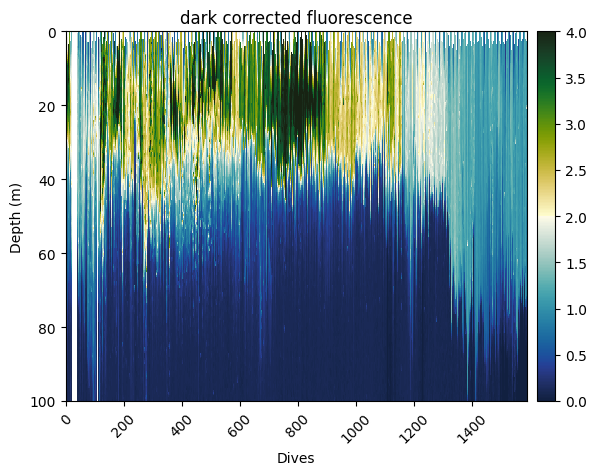

In [12]:
gt.plot(df_raw['PROFILE_NUMBER'], abs(df_raw['DEPTH_interp']), flr_dark, cmap=cmo.delta, robust=True)
plt.title('dark corrected fluorescence')
plt.ylim(100, 0)
plt.show()

In [13]:
#convert our fluo bbp dataset to a polar dataframe because it is easier.
data = [
    pl.Series("datetime",  dataset.TIME.data, dtype=pl.Datetime),
    pl.Series("prof", dataset.PROFILE_NUMBER.data, dtype=pl.Float64),
    pl.Series("depth", dataset.DEPTH.data, dtype=pl.Float32),
    pl.Series("bbp", dataset.BBP700_baseline.data, dtype=pl.Float32),
    pl.Series("fluo", flr_dark, dtype=pl.Float32),
]

df = pl.DataFrame(data)
df = df.with_columns((pl.col("fluo") / 2.5))
#define a function to detect if the profile is at day or night
def classify_day_night(dt):
    hour = dt.hour
    return "day" if 6 <= hour < 21 else "night"

# Add the new column
df = df.with_columns(
    pl.col("datetime").map_elements(lambda dt: classify_day_night(dt)).alias("day_night")
)

# Extract date part from datetime
df = df.with_columns(pl.col("datetime").dt.date().alias("date"))
df = df.with_columns(pl.col("depth").round(0).alias("depth_rounded"))
night_profiles = df.filter(
    (pl.col("day_night") == "night") & (pl.col("depth") <= 40)
)

# Compute the night fluo/bbp ratio
night_profiles = night_profiles.with_columns(
    (pl.col("fluo") / pl.col("bbp")).alias("fluo_bbp_ratio")
)

night_ratios_by_depth = night_profiles.group_by(["date"]).agg(
    pl.col("fluo_bbp_ratio").drop_nans().mean().alias("night_depth_ratio")
)

#compute the ratio for day profiles
day_profiles = df.filter(
    (pl.col("day_night") == "day") & (pl.col("depth") <= 40)
).with_columns(
    (pl.col("fluo") / pl.col("bbp")).alias("fluo_bbp_ratio")
)

#detect the quenched layer
quenched_layer = day_profiles.group_by("prof"
).agg(pl.col("fluo").drop_nans().max().alias("max_fluo_value")
)

max_depth_per_profile = (
    df.join(quenched_layer, on=["prof"])
    .filter(pl.col("fluo") == pl.col("max_fluo_value"))
    .select(["prof", "max_fluo_value", "depth"])
    .rename({"depth": "max_fluo_depth"})
).group_by(pl.col("prof")
).agg(pl.col("max_fluo_depth").drop_nans().mean())

# Join day profiles with corresponding night ratios by date and depth
day_profiles = day_profiles.join(
    night_ratios_by_depth, on=["date"], how="left"
).join(max_depth_per_profile, on = ["prof"], how = "left")
# Define a significant drop (e.g., 20% drop from night ratio)
day_profiles = day_profiles.with_columns(
    ((pl.col("fluo_bbp_ratio") < pl.col("night_depth_ratio") * 0.95) & (pl.col("depth") < pl.col("max_fluo_depth")))
    .alias("quenching_detected")
)
day_profiles = day_profiles.with_columns(
    pl.when(pl.col("quenching_detected"))
    .then(pl.col("bbp") * pl.col("night_depth_ratio"))
    .otherwise(pl.col("fluo"))
    .alias("fluo_unquenched")
)
df = df.join(day_profiles.select(["datetime", "depth", "fluo_unquenched"]), 
              on=["datetime", "depth"], how="left")

# Fill night profiles or uncorrected points with original fluo values
df = df.with_columns(
    pl.when(pl.col("fluo_unquenched").is_null())
    .then(pl.col("fluo"))
    .otherwise(pl.col("fluo_unquenched"))
    .alias("fluo_unquenched")
)

C:\Users\flapet\AppData\Local\Temp\ipykernel_14112\1721749003.py:18: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(


In [14]:
dataset['CHLA_corrected'] = ("N_MEASUREMENTS", df["fluo_unquenched"])

dataset['CHLA_corrected'].attrs = {
    'description': 'Chla fluorescence corrected for dark counts and quenching',
    'units' : 'mg.m-3',
    'quenching method': 'apply chla/bbp avaerage ratio from night profiles to day profiles',
}

In [15]:
dataset.to_netcdf(f"C:/Users/flapet/OneDrive - NOC/Documents/risc_glider_demo/Data/Gliders/DMQC/{glider_name}_intermediate.nc", mode='w', format='NETCDF4', engine='netcdf4')